## Perform SMOTE and Test the Results with Hyperparameter Tuning

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE



In [81]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

## Add the Medication Data to the protein data

In [82]:
clin_data = pd.read_csv('../data/raw/train_clinical_data.csv')
clin_data['upd23b_clinical_state_on_medication'] = clin_data['upd23b_clinical_state_on_medication'].fillna('Unknown')

# get dummies for on_medication column
clin_data_dummies = pd.get_dummies(clin_data, columns=['upd23b_clinical_state_on_medication'], drop_first=True)

clin_data_dummies = clin_data_dummies[['visit_id', 'upd23b_clinical_state_on_medication_On', 'upd23b_clinical_state_on_medication_Unknown']]

# merge the updrs data with the clinical data for dummy columns
updrs1_df = pd.merge(updrs1_df, clin_data_dummies, on='visit_id')
updrs2_df = pd.merge(updrs2_df, clin_data_dummies, on='visit_id')
updrs3_df = pd.merge(updrs3_df, clin_data_dummies, on='visit_id')


In [83]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

In [84]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

In [85]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

In [86]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [87]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [88]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat', 'upd23b_clinical_state_on_medication_On',
       'upd23b_clinical_state_on_medication_Unknown'],
      dtype='object', length=1206)

In [89]:
## create smote function
def smote_data(df, target):
    """
    Function to perform SMOTE on a dataframe with a target variable
    """
    # separate the target variable from the dataframe
    X = df.drop(columns=target)
    y = df[target]
    
    # perform smote on the data
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    
    # create a dataframe from the smote data
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    y_smote_df = pd.DataFrame(y_smote, columns=[target])
    
    # combine the X and y smote dataframes
    smote_df = pd.concat([X_smote_df, y_smote_df], axis=1)
    
    return smote_df

In [90]:
updrs1_df_smote = smote_data(updrs1_df[updrs1_df['kfold']!=0], 'updrs_1_cat')

In [91]:
updrs1_test_df = updrs1_df[updrs1_df['kfold']==0]

In [92]:
updrs1_df_smote['updrs_1_cat'].value_counts()

1    683
0    683
Name: updrs_1_cat, dtype: int64

In [93]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(1, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(1, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(1, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(1, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(1, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [94]:
# test the model function
# model = prepare_xgboost_model(xgb_hyperparams_df, 'updrs_1')
# model.get_params()

In [95]:
xgb_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_df]):
    model = XGBClassifier(random_state=42)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

In [96]:
xgb_results

{'updrs_1': {'auc': 0.6270879562212515,
  'acc': 0.8348745118687201,
  'prec': 0.7282913165266106,
  'recall': 0.280477461770368}}

In [97]:
model = XGBClassifier(random_state=42)
X_train_df = updrs1_df_smote.drop(columns = ['updrs_1_cat', 'visit_id', 'patient_id', 'kfold', 'updrs_1'])
y_train_df = updrs1_df_smote['updrs_1_cat']
X_test = updrs1_test_df.drop(columns = ['updrs_1_cat', 'visit_id', 'patient_id', 'kfold', 'updrs_1'])
y_test = updrs1_test_df['updrs_1_cat']

model.fit(X_train_df, y_train_df)

preds = model.predict_proba(X_test)[:,-1]

In [98]:
roc_auc_score(y_test, preds), accuracy_score(y_test, preds>0.4), precision_score(y_test, preds>0.4), recall_score(y_test, preds>0.4)

(0.7783217734258125,
 0.822429906542056,
 0.5714285714285714,
 0.46511627906976744)

In [99]:
def plot_precision_recall_accuracy(y_test, preds, updrs, model_name):
    thresholds = np.linspace(0, 1.0, num=100)  # Generating 100 threshold values between 0 and 1.0
    precisions = []
    recalls = []
    accuracies = []
    f1 = []

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        binary_preds = np.where(preds >= threshold, 1, 0)

        # Calculate precision, recall, and accuracy scores
        precision = precision_score(y_test, binary_preds)
        recall = recall_score(y_test, binary_preds)
        accuracy = accuracy_score(y_test, binary_preds)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Append scores to the respective lists
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1.append(f1_score)

    # Plot precision, recall, and accuracy against thresholds
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, f1, label='F1 Score')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{model_name} - {updrs}: Precision, Recall, F1 and Accuracy for Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return max(f1), thresholds[f1.index(max(f1))]
    

c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


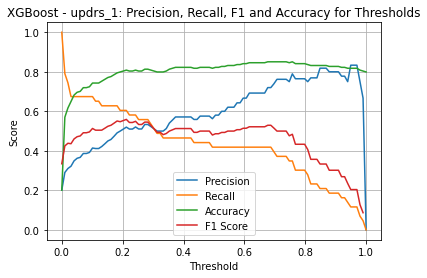

In [100]:
max_f1, thresh_ind = plot_precision_recall_accuracy(y_test, preds, "updrs_1", "XGBoost")

In [101]:
roc_auc_score(y_test, preds>0.33), accuracy_score(y_test, preds>0.33), precision_score(y_test, preds>0.33), recall_score(y_test, preds>0.33)

(0.674078607371141, 0.7990654205607477, 0.5, 0.46511627906976744)

## View XGBoost Results with Forecasting the UPDRS

In [102]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [103]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [104]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

In [105]:
updrs1_yr_test = updrs1_yr_df[updrs1_yr_df['kfold']==0]
updrs2_yr_test = updrs2_yr_df[updrs2_yr_df['kfold']==0]
updrs3_yr_test = updrs3_yr_df[updrs3_yr_df['kfold']==0]

updrs1_yr_df_smote = smote_data(updrs1_yr_df[updrs1_yr_df['kfold']!=0], 'updrs_1_cat')
updrs2_yr_df_smote = smote_data(updrs2_yr_df[updrs2_yr_df['kfold']!=0], 'updrs_2_cat')
updrs3_yr_df_smote = smote_data(updrs3_yr_df[updrs3_yr_df['kfold']!=0], 'updrs_3_cat')

In [106]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = XGBClassifier(random_state=42)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


UPDRS: updrs_2
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'ba

In [107]:
xgb_forecast_results

{'updrs_1': {'auc': 0.7334255520314714,
  'acc': 0.7348723222303954,
  'prec': 0.7497132554945056,
  'recall': 0.6926445578231293},
 'updrs_2': {'auc': 0.8374196066126336,
  'acc': 0.8359824521195153,
  'prec': 0.8676710253853823,
  'recall': 0.7918956043956045},
 'updrs_3': {'auc': 0.7132190143923913,
  'acc': 0.7104958496803848,
  'prec': 0.7494863467656416,
  'recall': 0.6450945913170021}}

In [108]:


def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [109]:
def train_xgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/xgboost_{updrs}_model_baseline_meds.sav'
    pickle.dump(model, open(filename, 'wb'))

    return model

In [110]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = XGBClassifier(random_state=42)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_xgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


AUC on Test Data: 0.7447280799112097
updrs_1 Results: 
Test AUC = 0.7447280799112097 
Train AUC = 1.0

AUC on Test Data: 0.8577777777777778
updrs_2 Results: 
Test AUC = 0.8577777777777778 
Train AUC = 1.0

AUC on Test Data: 0.7317216981132075
updrs_3 Results: 
Test AUC = 0.7317216981132075 
Train AUC = 1.0



c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


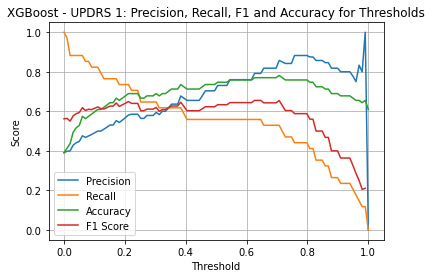

ROC-AUC: 0.7447280799112097 
Accuracy: 0.6896551724137931 
Precision: 0.5813953488372093 
Recall: 0.7352941176470589 
Threshold: 0.21


In [111]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_1_model_baseline_meds.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.21), \
    "\nPrecision:", precision_score(y_test1, preds>0.21), \
    "\nRecall:", recall_score(y_test1, preds>0.21), \
        "\nThreshold: 0.21")

0.8577777777777778 0.8409090909090909 0.72 0.72


c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


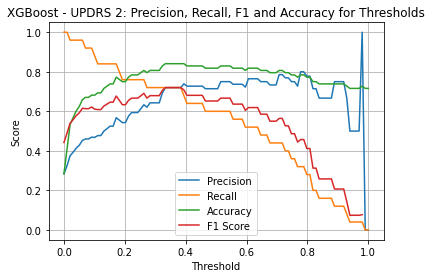

ROC-AUC: 0.8577777777777778 
Accuracy: 0.8409090909090909 
Precision: 0.72 
Recall: 0.72 
Threshold: 0.33


In [112]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_2_model_baseline_meds.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print(roc_auc_score(y_test2, preds), accuracy_score(y_test2, preds>0.33), precision_score(y_test2, preds>0.33), recall_score(y_test2, preds>0.33))

plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.33), \
    "\nPrecision:", precision_score(y_test2, preds>0.33), \
    "\nRecall:", recall_score(y_test2, preds>0.33), \
    "\nThreshold: 0.33")

0.7317216981132075 0.611764705882353 0.49122807017543857 0.875


c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


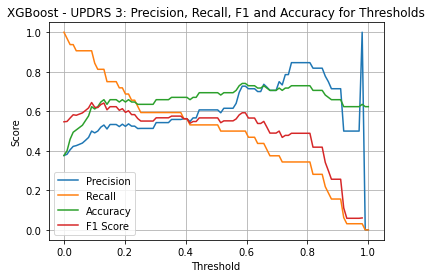

ROC-AUC: 0.7317216981132075 
Accuracy: 0.6470588235294118 
Precision: 0.52 
Recall: 0.8125 
Threshold: 0.12


In [113]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_3_model_baseline_meds.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print(roc_auc_score(y_test3, preds), accuracy_score(y_test3, preds>0.1), precision_score(y_test3, preds>0.1), recall_score(y_test3, preds>0.1))

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.12), \
    "\nPrecision:", precision_score(y_test3, preds>0.12), \
    "\nRecall:", recall_score(y_test3, preds>0.12), \
    "\nThreshold: 0.12")


## LGBoost Future Categorical Predictions

In [114]:
def train_lgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/lgboost_{updrs}_model_baseline_meds.pkl'
    joblib.dump(model, filename)

    return model

In [115]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = LGBMClassifier(random_state=42)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_lgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


AUC on Test Data: 0.7635960044395116
updrs_1 Results: 
Test AUC = 0.7635960044395116 
Train AUC = 1.0

AUC on Test Data: 0.8634920634920635
updrs_2 Results: 
Test AUC = 0.8634920634920635 
Train AUC = 1.0

AUC on Test Data: 0.7110849056603773
updrs_3 Results: 
Test AUC = 0.7110849056603773 
Train AUC = 1.0



0.7635960044395116 0.7126436781609196 0.6097560975609756 0.7352941176470589


c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


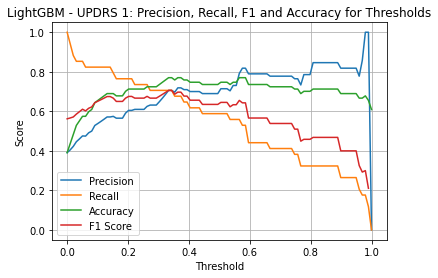

ROC-AUC: 0.7635960044395116 
Accuracy: 0.735632183908046 
Precision: 0.6486486486486487 
Recall: 0.7058823529411765 
Threshold: 0.3


In [116]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_1_model_baseline_meds.pkl')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print(roc_auc_score(y_test1, preds), accuracy_score(y_test1, preds>0.25), precision_score(y_test1, preds>0.25), recall_score(y_test1, preds>0.25))

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.3), \
    "\nPrecision:", precision_score(y_test1, preds>0.3), \
    "\nRecall:", recall_score(y_test1, preds>0.3), \
    "\nThreshold: 0.3")

c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


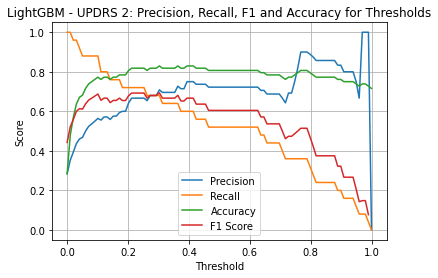

ROC-AUC: 0.8634920634920635 
Accuracy: 0.8295454545454546 
Precision: 0.7083333333333334 
Recall: 0.68 
Threshold: 0.31


In [117]:

# Load the saved model
model = joblib.load('../models/lgboost_updrs_2_model_baseline_meds.pkl')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.31), \
    "\nPrecision:", precision_score(y_test2, preds>0.31), \
    "\nRecall:", recall_score(y_test2, preds>0.31), \
    "\nThreshold: 0.31")


c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid 

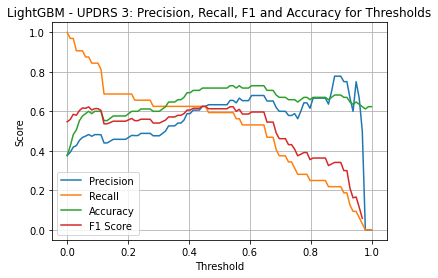

ROC-AUC: 0.7110849056603773 
Accuracy: 0.6 
Precision: 0.47619047619047616 
Recall: 0.625 
Threshold: 0.28


In [118]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_3_model_baseline_meds.pkl')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.28), \
    "\nPrecision:", precision_score(y_test3, preds>0.28), \
    "\nRecall:", recall_score(y_test3, preds>0.28), \
    "\nThreshold: 0.28")

## Compare Catboost Model

In [119]:
def train_catboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/catboost_{updrs}_model_baseline_meds.pkl'
    joblib.dump(model, filename)

    return model

In [120]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = CatBoostClassifier(random_state=42, verbose=False)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_catboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

AUC on Test Data: 0.7691453940066593
updrs_1 Results: 
Test AUC = 0.7691453940066593 
Train AUC = 1.0

AUC on Test Data: 0.8571428571428572
updrs_2 Results: 
Test AUC = 0.8571428571428572 
Train AUC = 1.0

AUC on Test Data: 0.7305424528301886
updrs_3 Results: 
Test AUC = 0.7305424528301886 
Train AUC = 1.0



c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefined

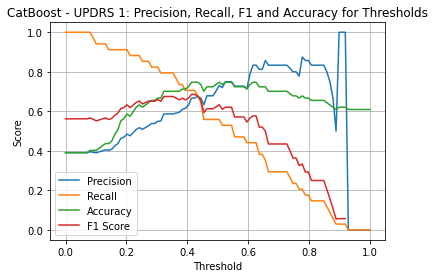

ROC-AUC: 0.7691453940066593 
Accuracy: 0.7011494252873564 
Precision: 0.5869565217391305 
Recall: 0.7941176470588235 
Threshold: 0.35


In [131]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_1_model_baseline_meds.pkl')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.35), \
    "\nPrecision:", precision_score(y_test1, preds>0.35), \
    "\nRecall:", recall_score(y_test1, preds>0.35), \
    "\nThreshold: 0.35")

c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefined

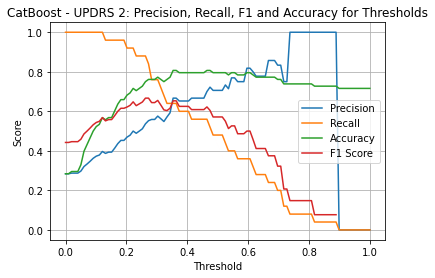

ROC-AUC: 0.8571428571428572 
Accuracy: 0.7727272727272727 
Precision: 0.5757575757575758 
Recall: 0.76 
Threshold: 0.30


In [130]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_2_model_baseline_meds.pkl')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.30), \
    "\nPrecision:", precision_score(y_test2, preds>0.30), \
    "\nRecall:", recall_score(y_test2, preds>0.30), \
    "\nThreshold: 0.30")

c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Dagart\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\Dagart\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefined

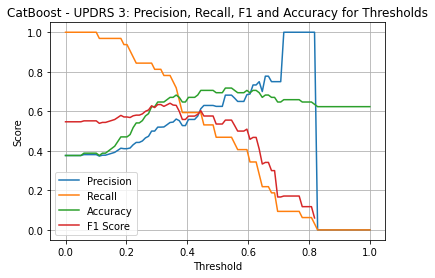

ROC-AUC: 0.7305424528301886 
Accuracy: 0.6823529411764706 
Precision: 0.5555555555555556 
Recall: 0.78125 
Threshold: 0.35


In [126]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_3_model_baseline_meds.pkl')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.35), \
    "\nPrecision:", precision_score(y_test3, preds>0.35), \
    "\nRecall:", recall_score(y_test3, preds>0.35), \
    "\nThreshold: 0.35")

# -----------------------------CHECK RESULTS -------------------------------------

In [ ]:
def train_catboost(train_df, test_df, updrs):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_val = val_df.drop([f'{updrs}_cat','kfold'] axis=1)
    y_val = val_df[f'{updrs}_cat']

    # Define the CatBoost classifier
    model = CatBoostClassifier(iterations=1000, eval_metric='AUC', random_seed=42)

    # Fit the model on the training data
    model.fit(features, 
              target,
                #early_stopping_rounds=50, 
                verbose=100)

    # Make predictions on the test data
    predictions = model.predict_proba(test_df)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(test_df[f'{updrs}_cat'], predictions)
    print("AUC on Test Data:", auc)

    # Save the best iteration of the model
    model.save_model(f'../models/catboost_{updrs}_model.cbm', format='cbm', pool=None)

    return model

In [ ]:
# train and save the best catboost model for each updrs
cboost_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}



    

5 Kfolds created for updrs_1_cat
Learning rate set to 0.023058
0:	test: 0.4894349	best: 0.4894349 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.6599509	best: 0.6633907 (98)	total: 20.3s	remaining: 3m
200:	test: 0.6914005	best: 0.6914005 (169)	total: 38.9s	remaining: 2m 34s
300:	test: 0.7027027	best: 0.7071253 (287)	total: 57.5s	remaining: 2m 13s
400:	test: 0.7115479	best: 0.7154791 (386)	total: 1m 16s	remaining: 1m 53s
500:	test: 0.7159705	best: 0.7169533 (477)	total: 1m 34s	remaining: 1m 34s
600:	test: 0.7130221	best: 0.7169533 (477)	total: 1m 53s	remaining: 1m 15s
700:	test: 0.7135135	best: 0.7169533 (477)	total: 2m 11s	remaining: 56.3s
800:	test: 0.7233415	best: 0.7243243 (785)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7233415	best: 0.7248157 (808)	total: 2m 49s	remaining: 18.6s
999:	test: 0.7267813	best: 0.7272727 (960)	total: 3m 7s	remaining: 0us

bestTest = 0.7272727273
bestIteration = 960

Shrink model to first 961 iterations.
AUC on Test Data: 0.7326781326781326


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6525798525798526, 1.0)

In [ ]:
for updrs, df in zip(['updrs_2'], [updrs2_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_2_cat
Learning rate set to 0.023058
0:	test: 0.5623974	best: 0.5623974 (0)	total: 206ms	remaining: 3m 26s
100:	test: 0.7695676	best: 0.7766831 (95)	total: 18.2s	remaining: 2m 42s
200:	test: 0.7996716	best: 0.8111658 (176)	total: 36.1s	remaining: 2m 23s
300:	test: 0.8292282	best: 0.8314176 (299)	total: 54.1s	remaining: 2m 5s
400:	test: 0.8445539	best: 0.8467433 (381)	total: 1m 12s	remaining: 1m 48s
500:	test: 0.8494800	best: 0.8549535 (464)	total: 1m 30s	remaining: 1m 29s
600:	test: 0.8560482	best: 0.8565955 (581)	total: 1m 48s	remaining: 1m 11s
700:	test: 0.8555008	best: 0.8582375 (674)	total: 2m 6s	remaining: 54s
800:	test: 0.8587849	best: 0.8587849 (738)	total: 2m 26s	remaining: 36.4s
900:	test: 0.8576902	best: 0.8593322 (804)	total: 2m 45s	remaining: 18.2s
999:	test: 0.8587849	best: 0.8604269 (946)	total: 3m 4s	remaining: 0us

bestTest = 0.8604269294
bestIteration = 946

Shrink model to first 947 iterations.
AUC on Test Data: 0.8292282430213465


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6737821565407772, 1.0)

In [ ]:
for updrs, df in zip(['updrs_3'], [updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_3_cat
Learning rate set to 0.023037
0:	test: 0.5795918	best: 0.5795918 (0)	total: 212ms	remaining: 3m 32s
100:	test: 0.6540816	best: 0.6709184 (92)	total: 19s	remaining: 2m 49s
200:	test: 0.6943878	best: 0.6989796 (191)	total: 40.1s	remaining: 2m 39s
300:	test: 0.7306122	best: 0.7311224 (294)	total: 1m 1s	remaining: 2m 23s
400:	test: 0.7372449	best: 0.7403061 (359)	total: 1m 22s	remaining: 2m 3s
500:	test: 0.7494898	best: 0.7510204 (493)	total: 1m 39s	remaining: 1m 39s
600:	test: 0.7530612	best: 0.7556122 (572)	total: 1m 56s	remaining: 1m 17s
700:	test: 0.7551020	best: 0.7571429 (689)	total: 2m 13s	remaining: 57s
800:	test: 0.7586735	best: 0.7602041 (780)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7576531	best: 0.7612245 (822)	total: 2m 47s	remaining: 18.4s
999:	test: 0.7596939	best: 0.7612245 (822)	total: 3m 4s	remaining: 0us

bestTest = 0.7612244898
bestIteration = 822

Shrink model to first 823 iterations.
AUC on Test Data: 0.7775510204081633


In [ ]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6303571428571428, 1.0)

## Compare to Logistic Regression Model

In [ ]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [ ]:
updrs1_results

(0.511721383287093,
 0.780847703040674,
 0.32282051282051283,
 0.062211088895139766)

In [ ]:
updrs2_results

(0.5258909849605227,
 0.8464349962704578,
 0.42333333333333323,
 0.07048988874546684)

In [ ]:
updrs3_results

(0.5240749211448716,
 0.8194894035589735,
 0.3485714285714286,
 0.07900396151669495)

## Forecast with Logistic Regression

In [ ]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [ ]:
updrs1_forecast_results

(0.5634874999789138,
 0.5994172665293609,
 0.4912421630094044,
 0.3920253253358589)

In [ ]:
updrs2_forecast_results

(0.582742150911908, 0.6805340492840493, 0.4779128959276018, 0.3289821193299454)

In [ ]:
updrs3_forecast_results

(0.5758538282007636,
 0.6218648310387985,
 0.5047414576826341,
 0.3744481451117032)